In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from pca import pca as pcaf

import matplotlib as mpl
import colourmap
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# ANÁLISIS ESTADÍSTICO MULTIVARIADO
Se presentan algunas rutinas básicas para el Análisis de Componentes Principales y de Agrupamiento (Cluster) utilizando resultados de análisis fisicoquímicos de agua subterránea (CAMPUS UNAL 2023). Las concentraciones se reportan en meq/L.
Para la preparación de la base de datos, se generan algunos estadísticos y gráficos descriptivos, evaluación de la normalidad de los parámetros y estandarización de los datos.

In [2]:
medf = pd.read_excel('PuntosMuestreoUNAL.xlsx',sheet_name='Muestreo meqL')

medf1 = medf[['Punto de Control','pH', 'HCO3', 'CO3', 'Ca', 'Mg', 'Fe', 'Mn', 'K', 'Na', 'F', 'NO2', 'NO3', 'Cl', 'SO4', 'PO4', 'TDS']]

medf2 = medf1.dropna()

##  Matriz de correlación de los parámetros
Se desea realizar una correlación entre los paramétros medidos, para ello se obtiene una matriz de correlación entre los componentes de las muestras, con 1 en la diagonal principal que correlaciona la misma variable.

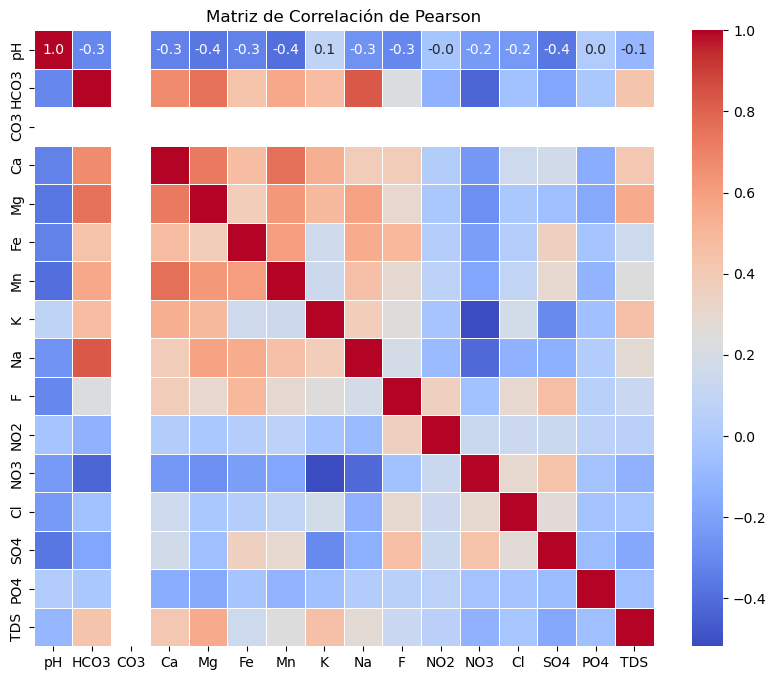

In [3]:
iris = medf2[['pH', 'HCO3', 'CO3', 'Ca', 'Mg', 'Fe', 'Mn', 'K', 'Na', 'F', 'NO2', 'NO3', 'Cl', 'SO4', 'PO4', 'TDS']]
# iris = iris.drop('CO3',axis=1)
matriz_pearson = iris.corr(method='pearson')

#Figura de matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_pearson, annot=True, fmt=".1f",cmap='coolwarm', linewidths=.5)
plt.title('Matriz de Correlación de Pearson')
plt.show()

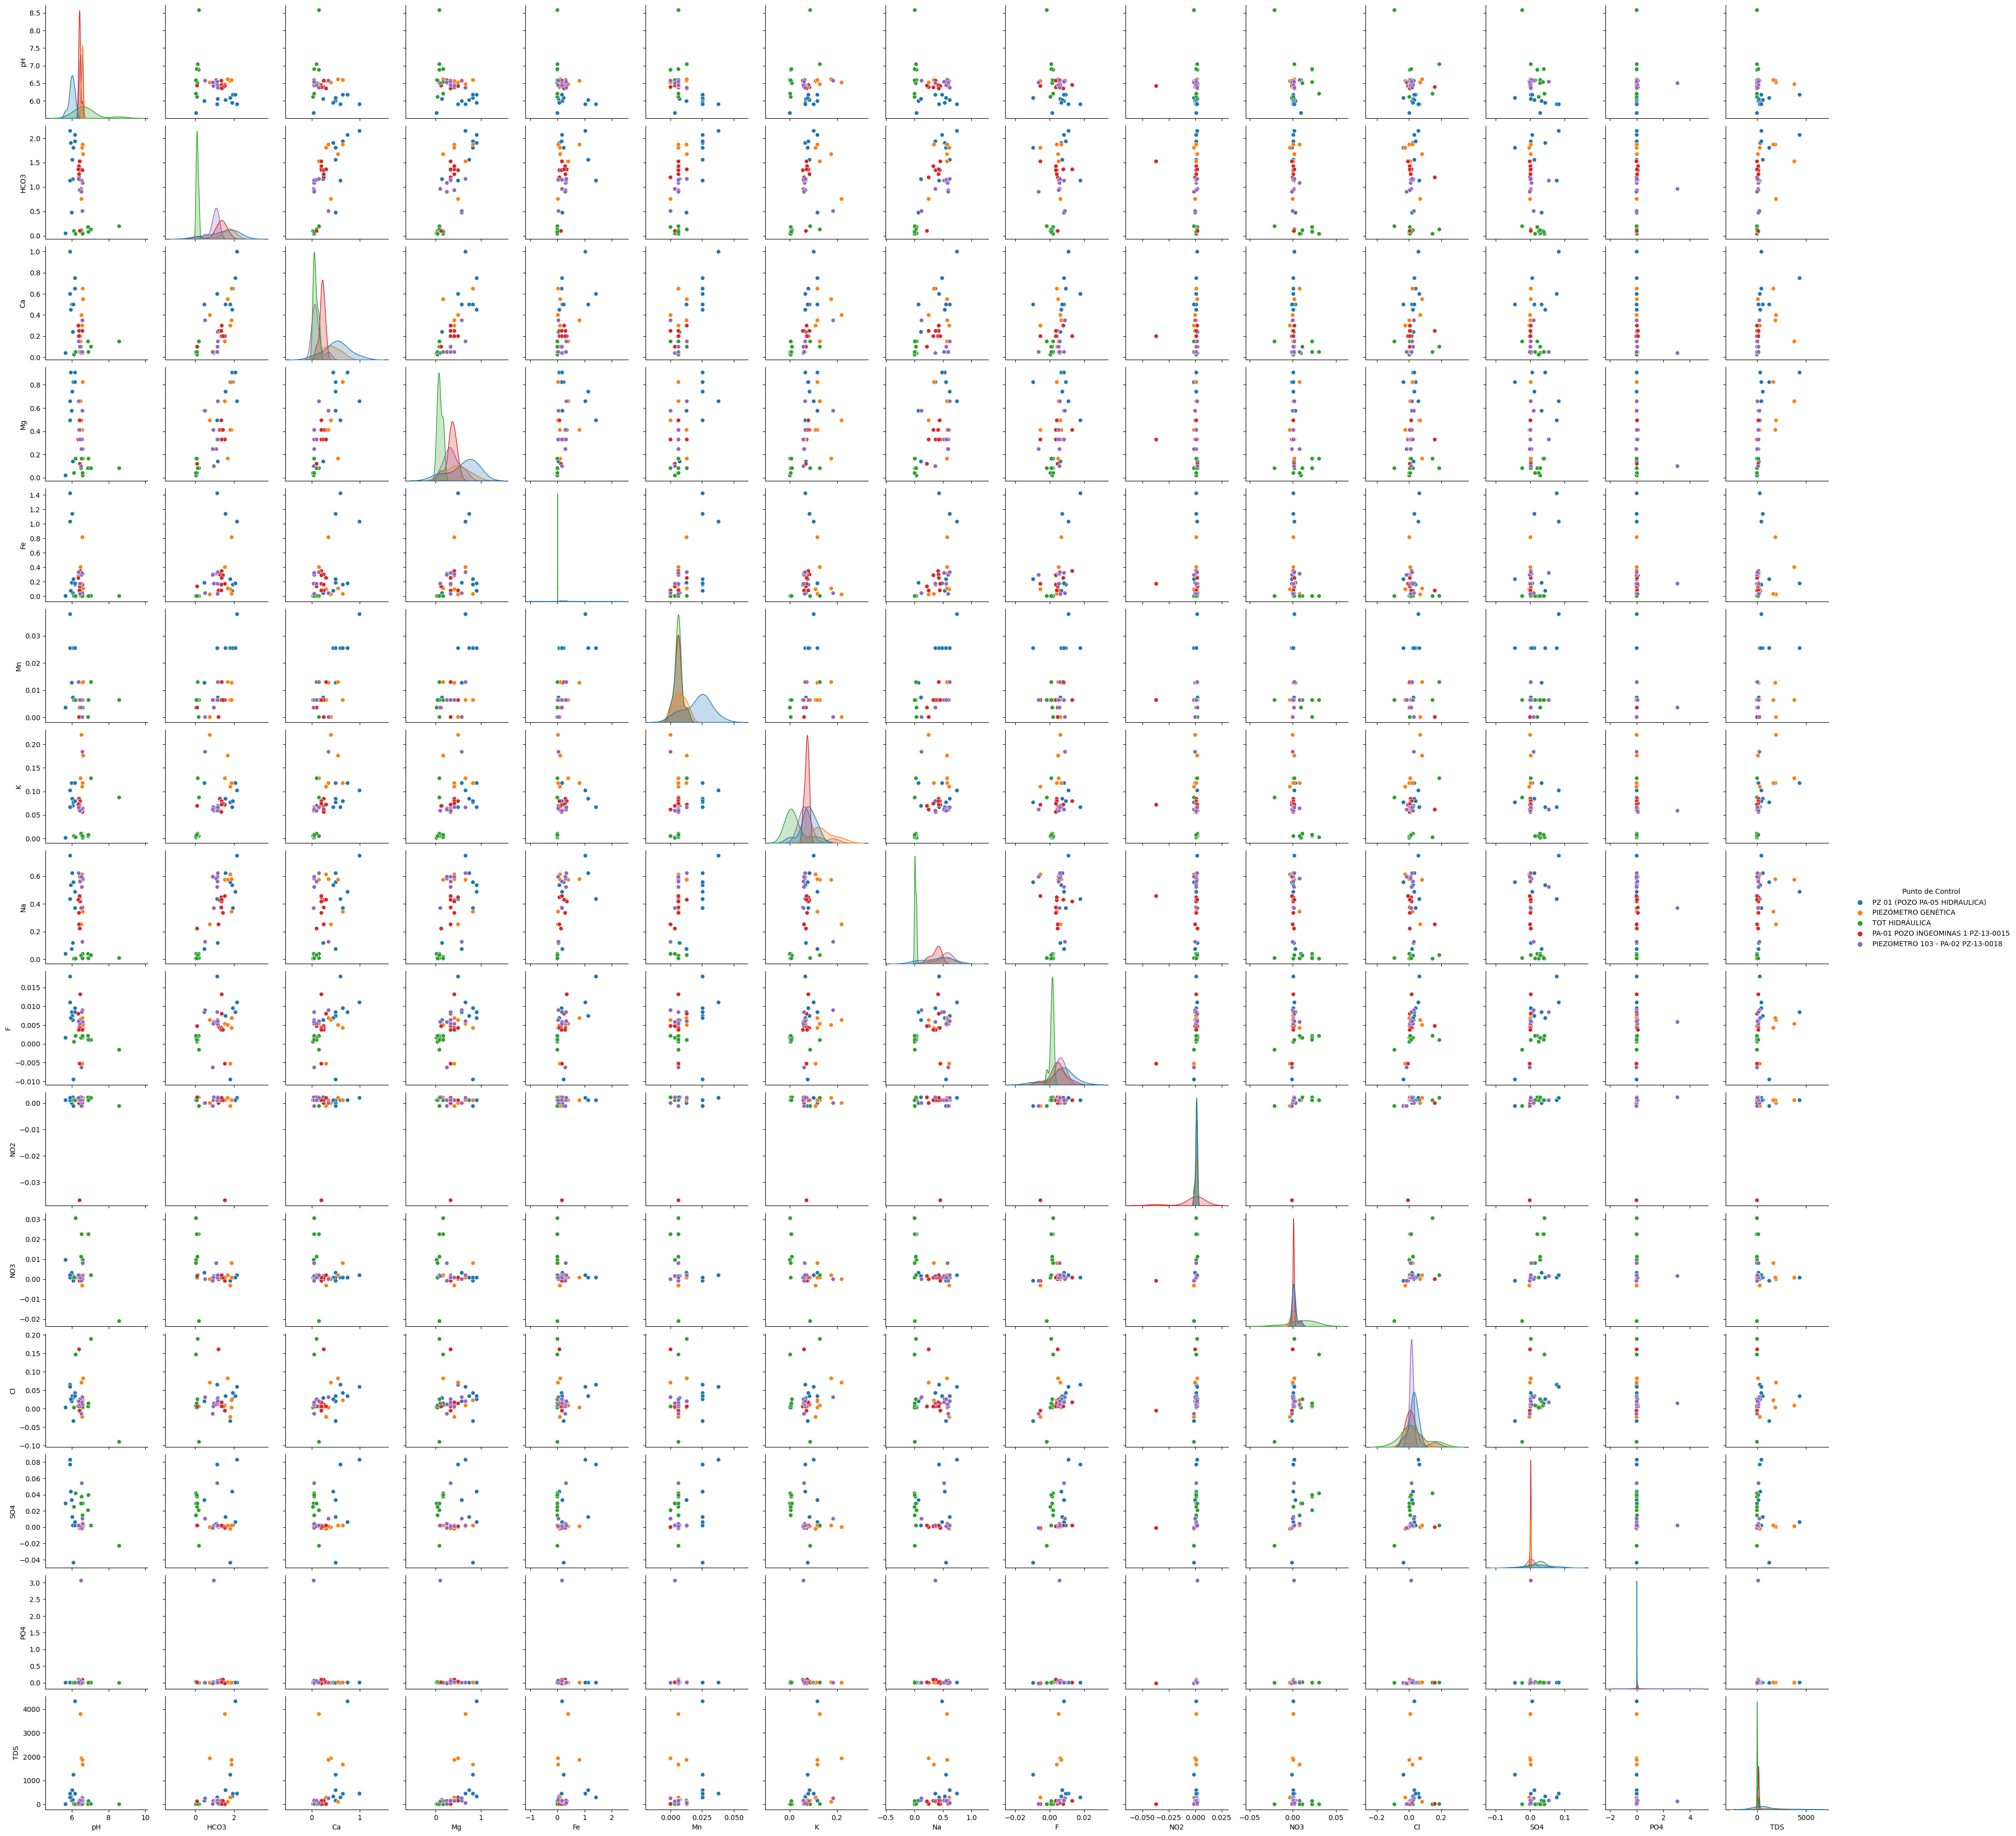

In [4]:
medf2 = medf2.drop('CO3',axis=1)
sns.pairplot(medf2,hue='Punto de Control',diag_kind='kde')

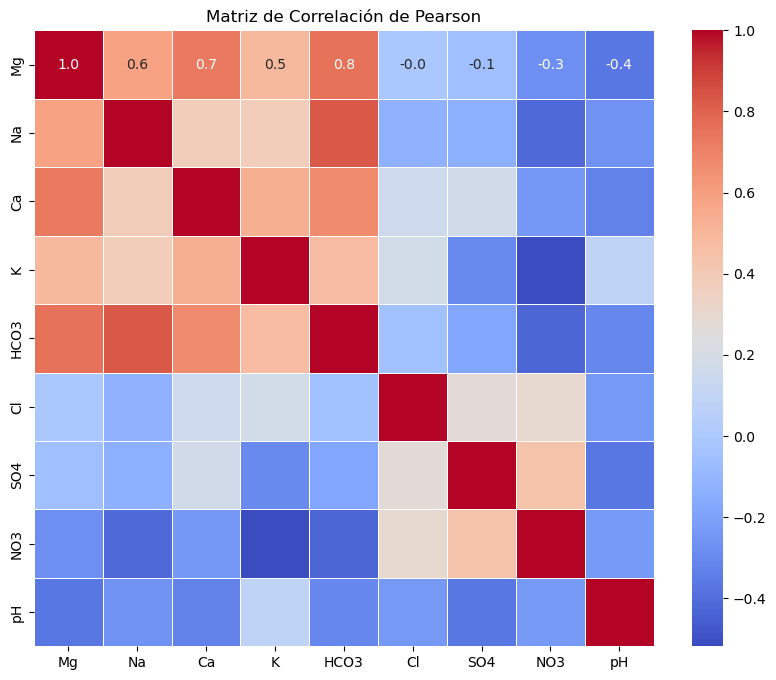

In [5]:
iris = medf[['Mg','Na','Ca','K','HCO3','Cl','SO4','NO3','pH']]
matriz_pearson = iris.corr(method='pearson')

#Figura de matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_pearson, annot=True, fmt=".1f",cmap='coolwarm', linewidths=.5)
plt.title('Matriz de Correlación de Pearson')
plt.show()

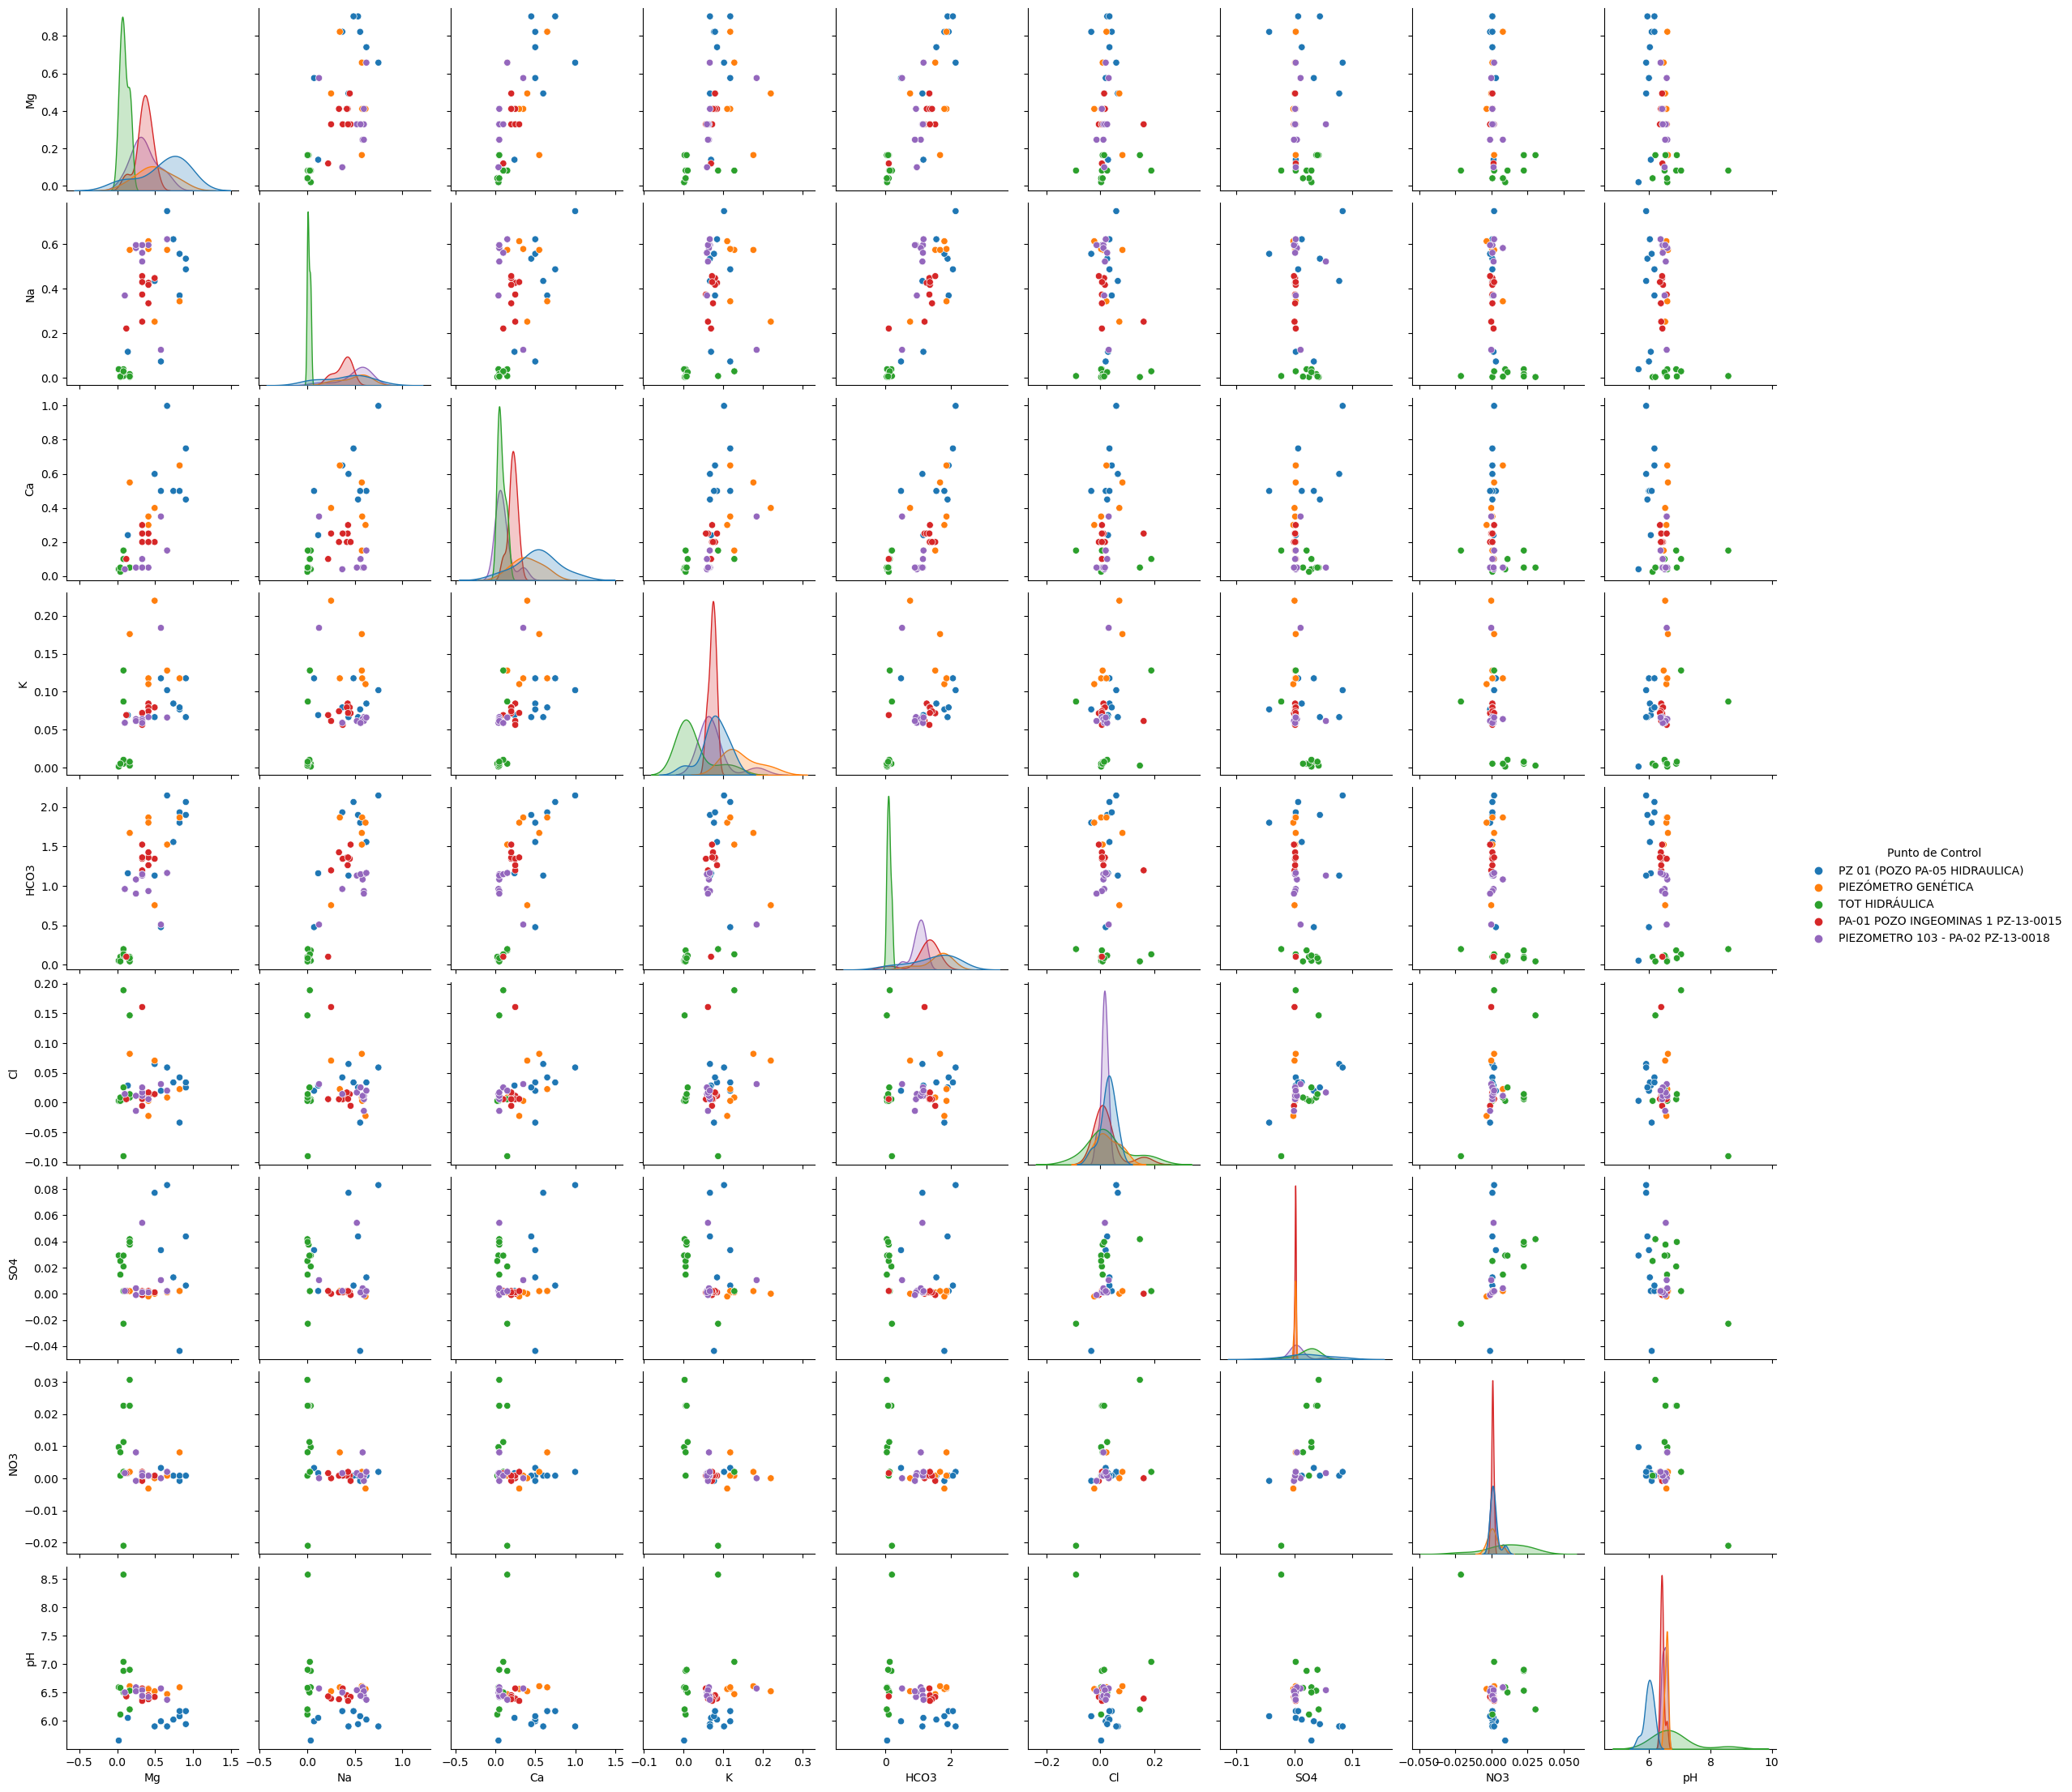

In [6]:
iris["Punto de Control"] = medf['Punto de Control']
sns.pairplot(iris,hue='Punto de Control',diag_kind='kde')

## Evaluación de la normalidad muestras


In [7]:
print(pg.normality(iris))

             W          pval  normal
Mg    0.931569  1.184404e-02   False
Na    0.886283  4.232732e-04   False
Ca    0.855230  5.951834e-05   False
K     0.911222  2.453290e-03   False
HCO3  0.909995  2.240470e-03   False
Cl    0.784422  1.360360e-06   False
SO4   0.829066  1.336196e-05   False
NO3   0.720776  8.100096e-08   False
pH    0.746018  2.354251e-07   False


Ninguno de los parámetros se distribuye normalmente, entonces se deben buscar tranformaciones que permitan lograr una distribución normal de los datos. Una de las transformaciones más usadas es la tranfromación logarítmica. 

In [8]:
iris1 = iris.drop('Punto de Control', axis=1)
# Transformación logarítmica
Norm = np.log10(iris1) 
print(pg.normality(Norm))

             W          pval  normal
Mg    0.905091  1.566113e-03   False
Na    0.771349  7.343385e-07   False
Ca    0.937168  1.869479e-02   False
K     0.753730  3.303597e-07   False
HCO3  0.788899  1.688616e-06   False
Cl    0.966419  2.897328e-01    True
SO4   0.884848  8.346828e-04   False
NO3   0.845568  8.488425e-05   False
pH    0.802684  3.342206e-06   False


# Estandarización de datos

In [9]:
standardisedX = scale(iris1)
standardisedX = pd.DataFrame(standardisedX, index=iris1.index, columns=iris1.columns)

standardisedX.apply(np.mean)
standardisedX.apply(np.std)
print(pg.normality(standardisedX))

             W          pval  normal
Mg    0.931569  1.184404e-02   False
Na    0.886283  4.232826e-04   False
Ca    0.855230  5.951834e-05   False
K     0.911223  2.453351e-03   False
HCO3  0.909995  2.240470e-03   False
Cl    0.784421  1.360341e-06   False
SO4   0.829066  1.336196e-05   False
NO3   0.720776  8.100159e-08   False
pH    0.746019  2.354263e-07   False


# ANALISIS DE COMPONENTES PRINCIPALES

In [10]:
pca = PCA().fit(standardisedX)

In [11]:
def pca_summary(pca, standardised_data, out=True):
    names = ["PC"+str(i) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    a = list(np.std(pca.transform(standardised_data), axis=0))
    b = list(pca.explained_variance_ratio_)
    c = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    columns = pd.MultiIndex.from_tuples([("sdev", "Standard deviation"), ("varprop", "Proportion of Variance"), ("cumprop", "Cumulative Proportion")])
    summary = pd.DataFrame(zip(a, b, c), index=names, columns=columns)
    if out:
        print("Importance of components:")
        display(summary)
    return summary

In [12]:
summary = pca_summary(pca, standardisedX)

Importance of components:


,sdev,varprop,cumprop
,Standard deviation,Proportion of Variance,Cumulative Proportion
PC1,1.932225,0.414832,0.414832
PC2,1.427436,0.226397,0.641229
PC3,1.049057,0.122280,0.763509
PC4,0.819087,0.074545,0.838054
PC5,0.707049,0.055547,0.893601
PC6,0.645246,0.046260,0.939861
PC7,0.519418,0.029977,0.969838
PC8,0.450848,0.022585,0.992423
PC9,0.261133,0.007577,1.000000


## Selección de número de componentes principales a retener

### Scree plot
Se pueden retener los componentes de acuerdo con el cambio de pendiente más fuerte en el Scree plot (hasta el componente 4). 

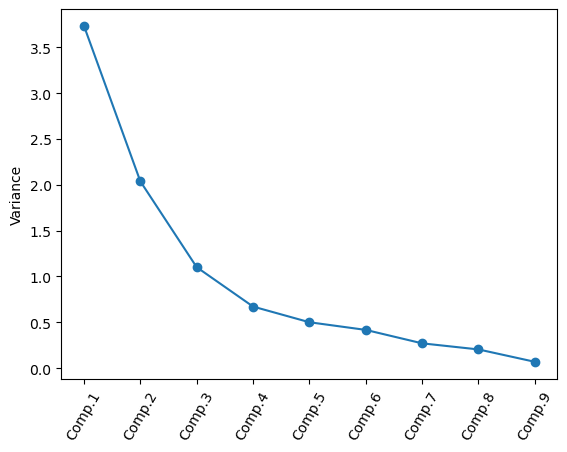

In [13]:
def screeplot(pca, standardised_values):
    y = np.std(pca.transform(standardised_values), axis=0)**2
    x = np.arange(len(y)) + 1
    plt.plot(x, y, "o-")
    plt.xticks(x, ["Comp."+str(i) for i in x], rotation=60)
    plt.ylabel("Variance")
    plt.show()

screeplot(pca, standardisedX)

### Citerio de Kaisser
Se pueden retener los componentes cuya varianza este por encima de 1. Para el ejemplo se conservarían los tres primeros componentes.

In [14]:
summary.sdev**2

,Standard deviation
PC1,3.733492
PC2,2.037572
PC3,1.100520
PC4,0.670904
PC5,0.499919
PC6,0.416343
PC7,0.269796
PC8,0.203264
PC9,0.068191


### Varianza acumulada
Se puede tambien verificar el porcentaje acumulado de la varianza explicada por los componentes. Es importante observar que con sólo 2 componentes se alcanza un 61% y con el tercer componente hasta el 78%.

## Pesos de los Componentes principales

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [9] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[6]


[scatterd] >INFO> Create scatterplot


[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


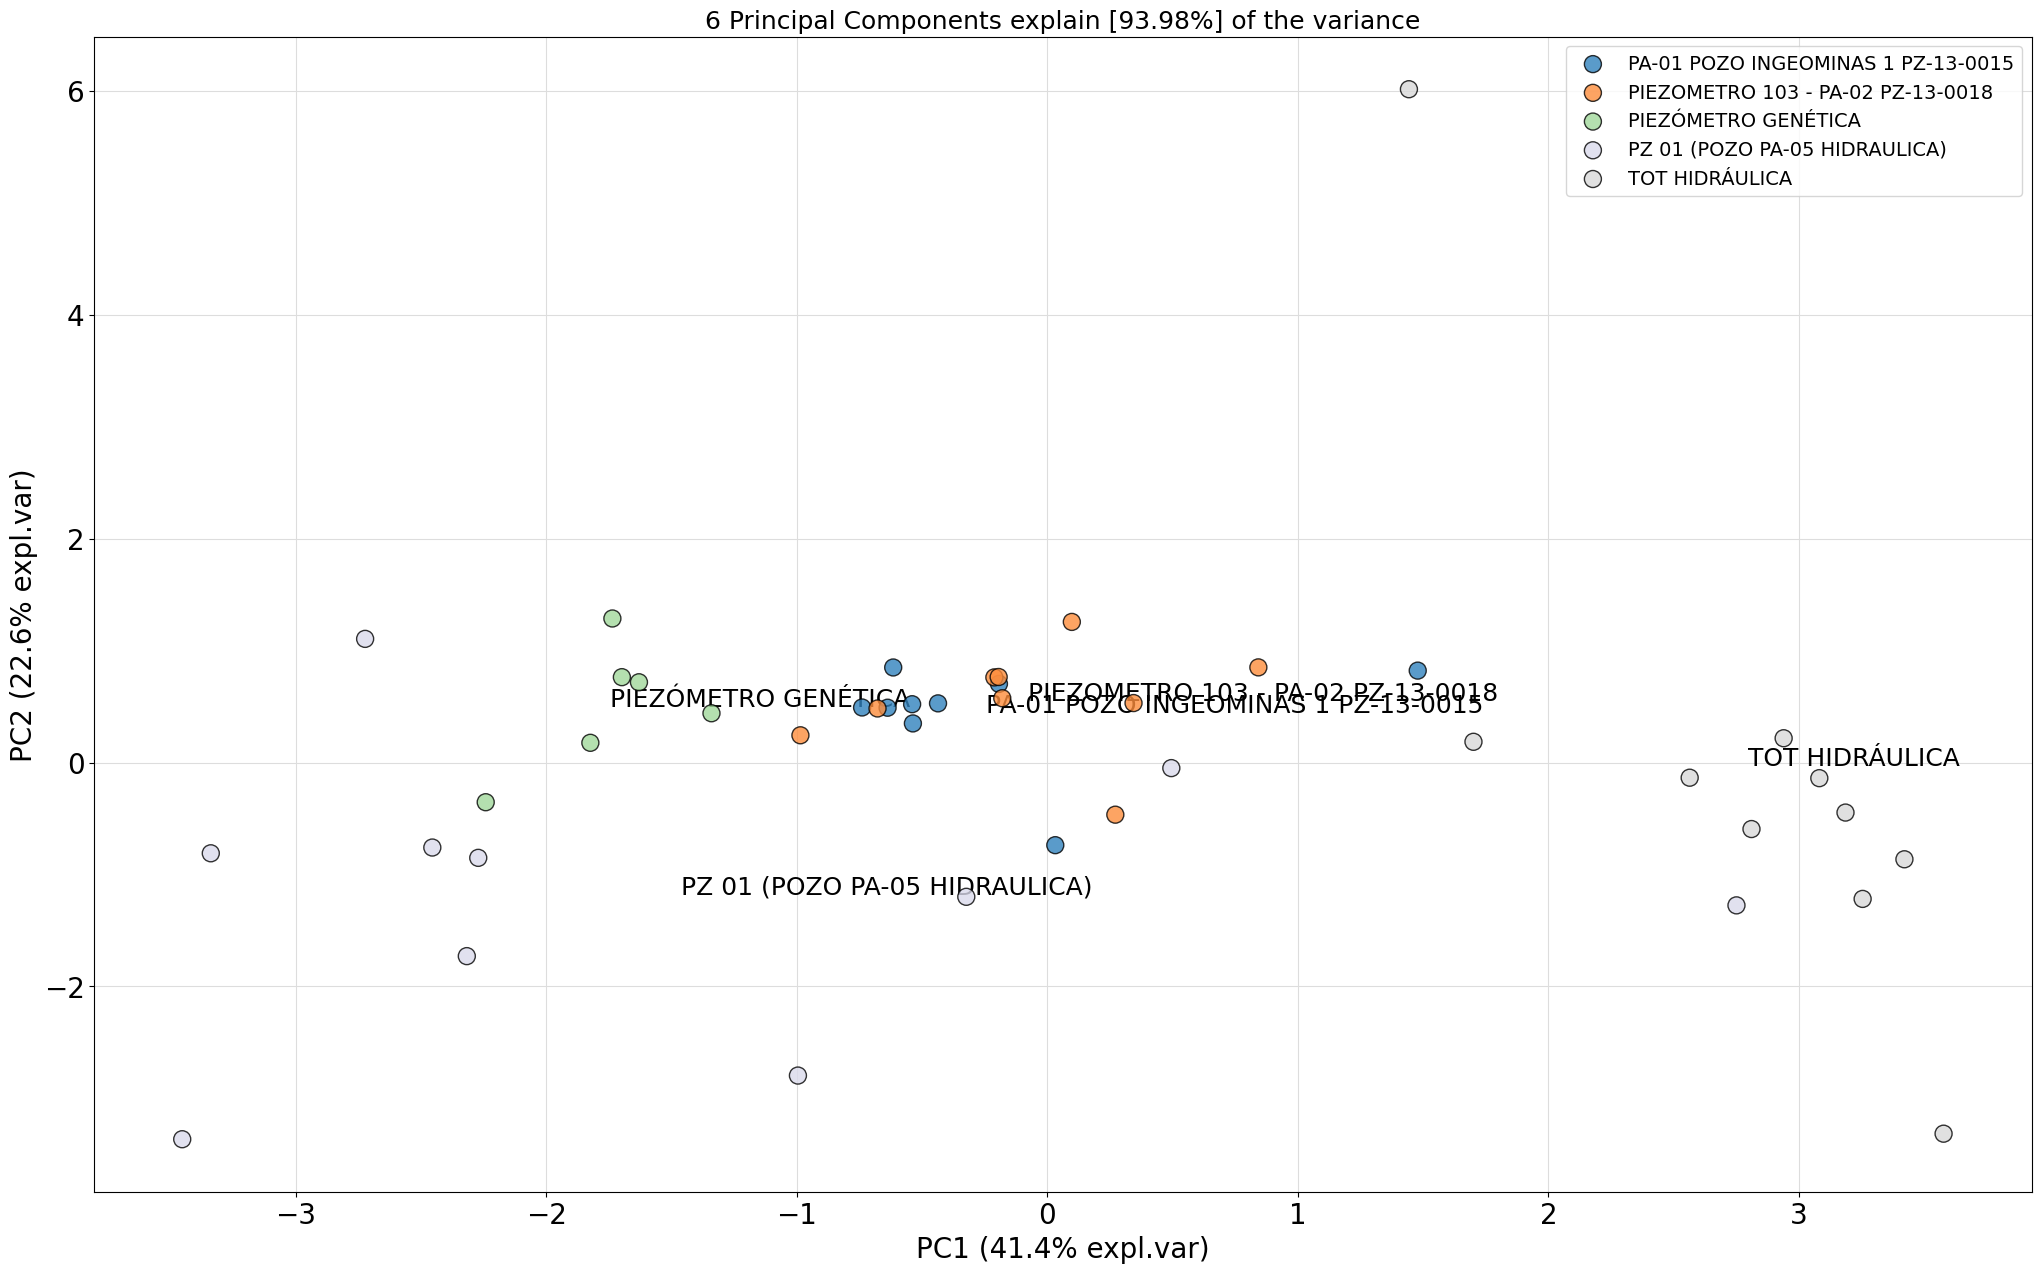

In [15]:
#Asignar índices a la base de datos.
label = iris1.columns
standardisedX.set_index(iris['Punto de Control'], inplace=True) 

# model = pcaf(n_components=0.95)
model = pcaf(n_components=6) #Solo conserva 3 componentes

results = model.fit_transform(standardisedX)

fig, ax = model.scatter()

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.


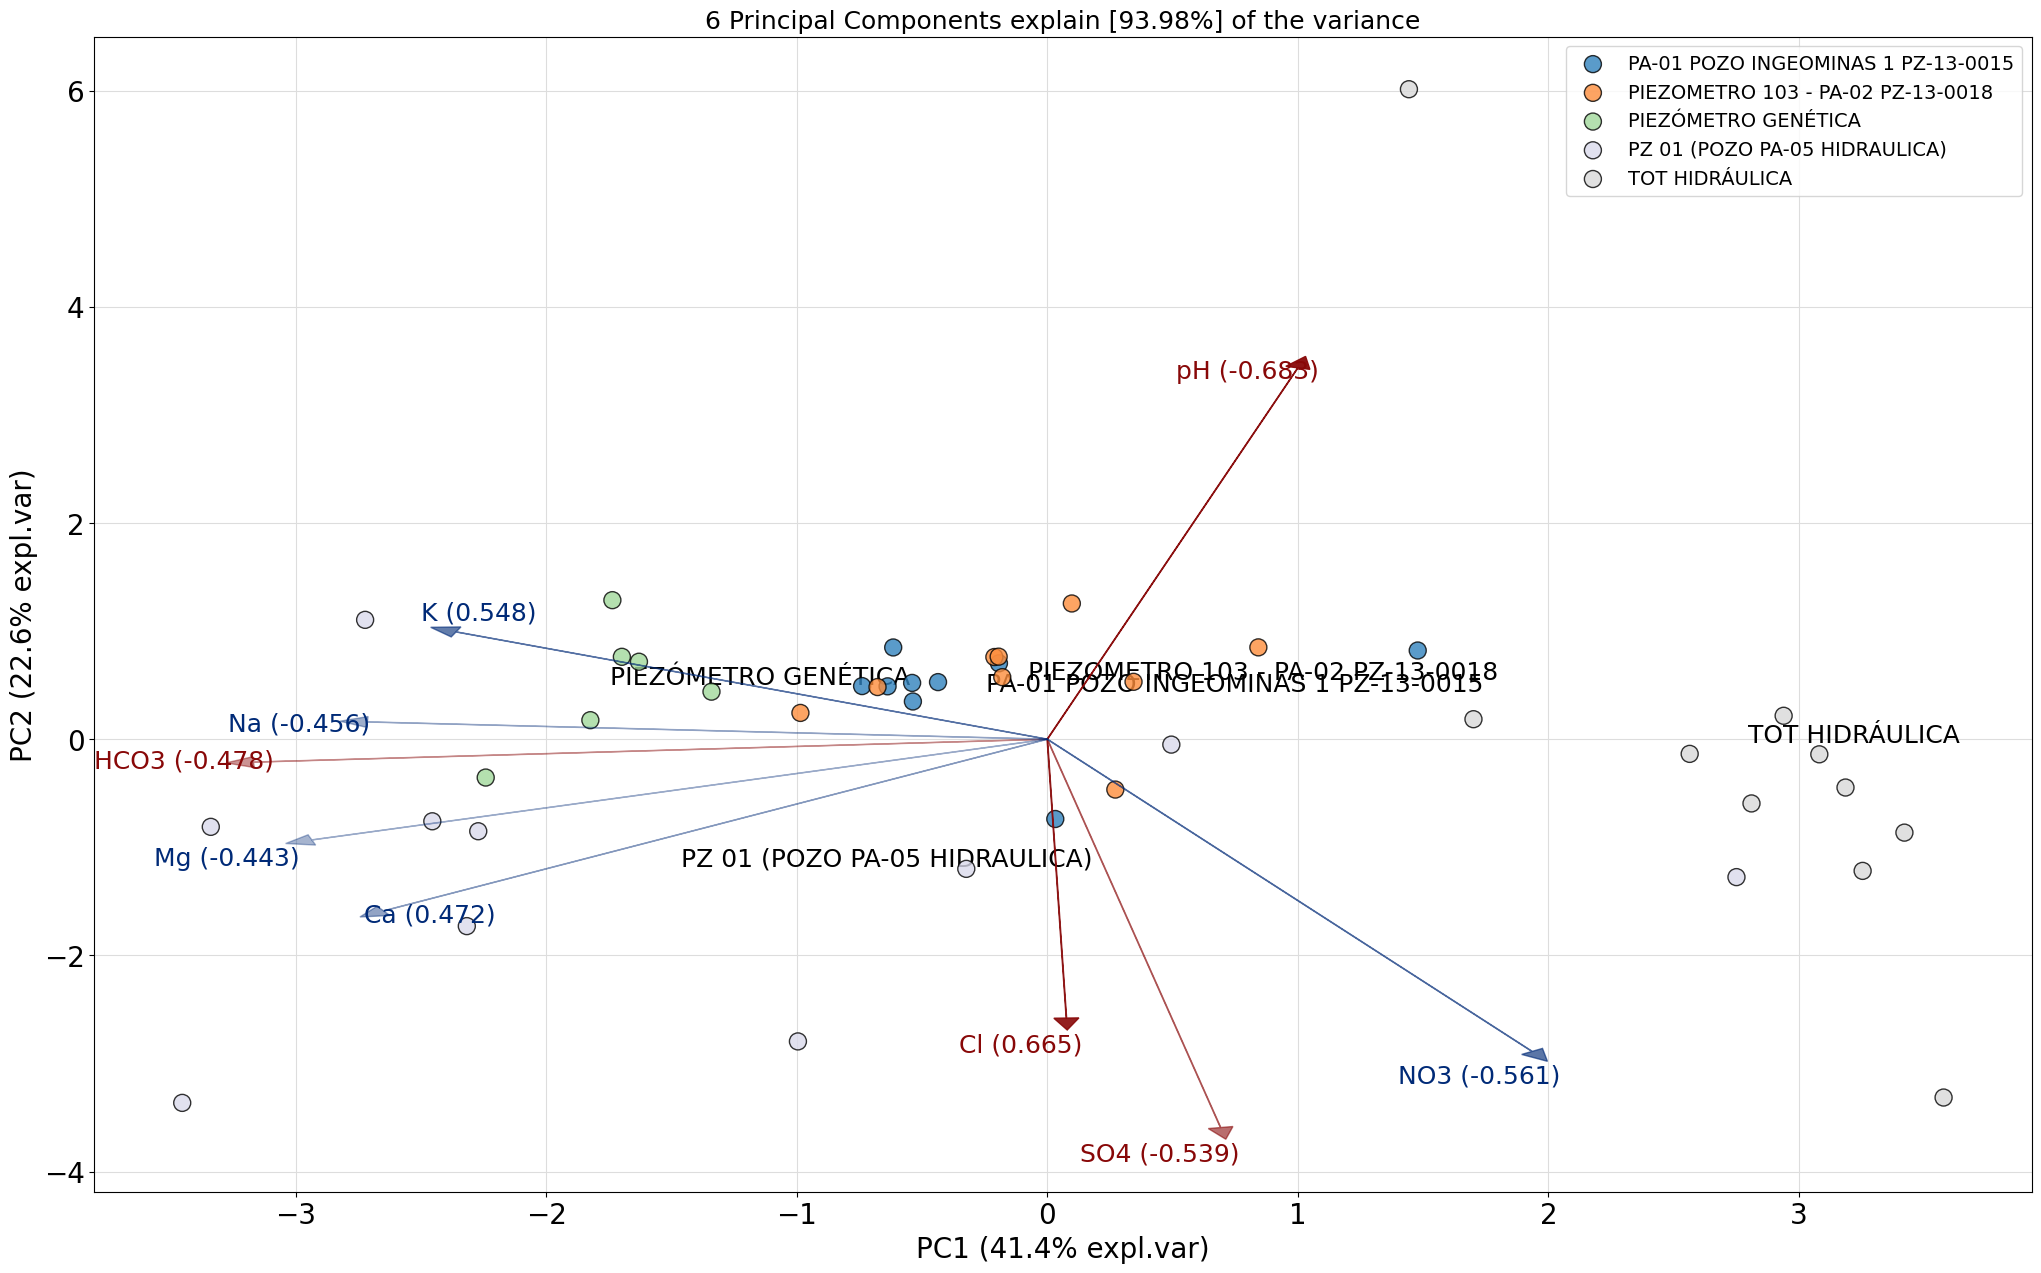

In [16]:
fig, ax = model.biplot(n_feat=9, PC=[0,1])

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.


(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': '6 Principal Components explain [93.98%] of the variance'}, xlabel='PC1 (41.4% expl.var)', ylabel='PC2 (22.6% expl.var)'>)

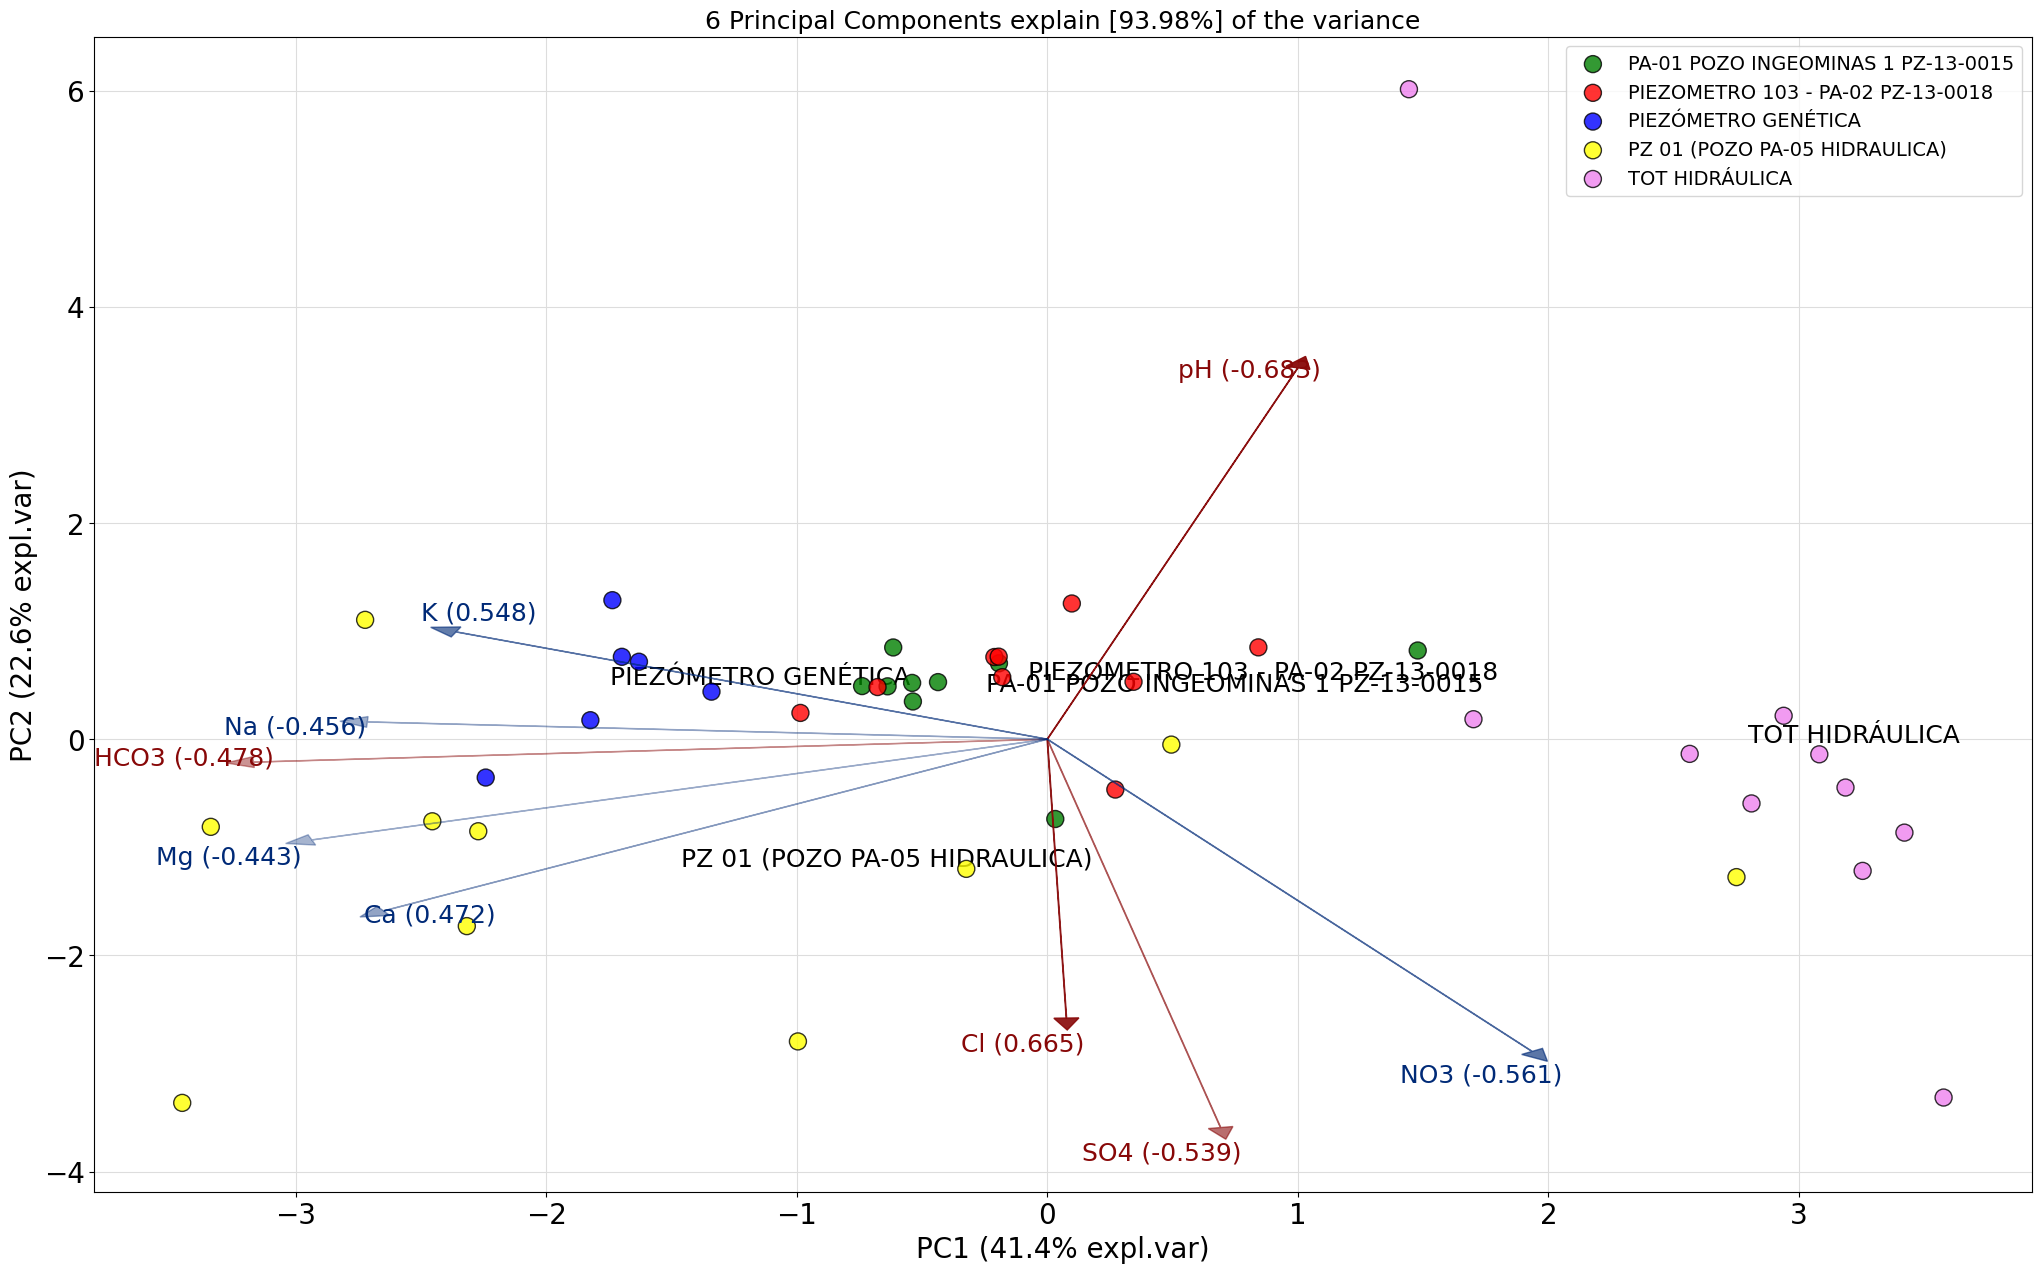

In [17]:
model.biplot(cmap=mpl.colors.ListedColormap(['green', 'red', 'blue','yellow','violet']))

# Agrupamiento de datos

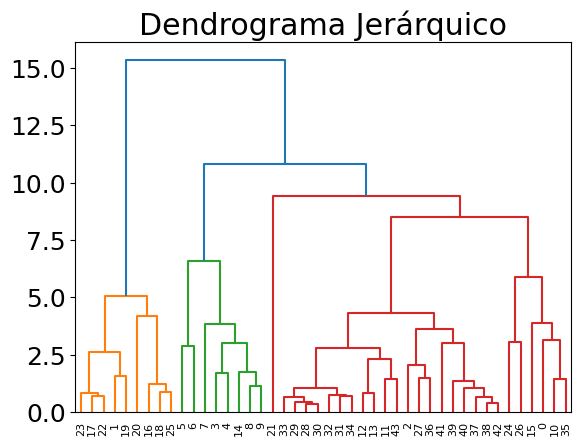

In [18]:
# Enlace jerárquico
enlace = linkage(standardisedX, 'ward')

# Dendrograma
dendrograma = dendrogram(enlace)

# Mostrar el dendrograma
plt.title('Dendrograma Jerárquico')
plt.show()

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.


(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': '6 Principal Components explain [93.98%] of the variance'}, xlabel='PC1 (41.4% expl.var)', ylabel='PC2 (22.6% expl.var)'>)

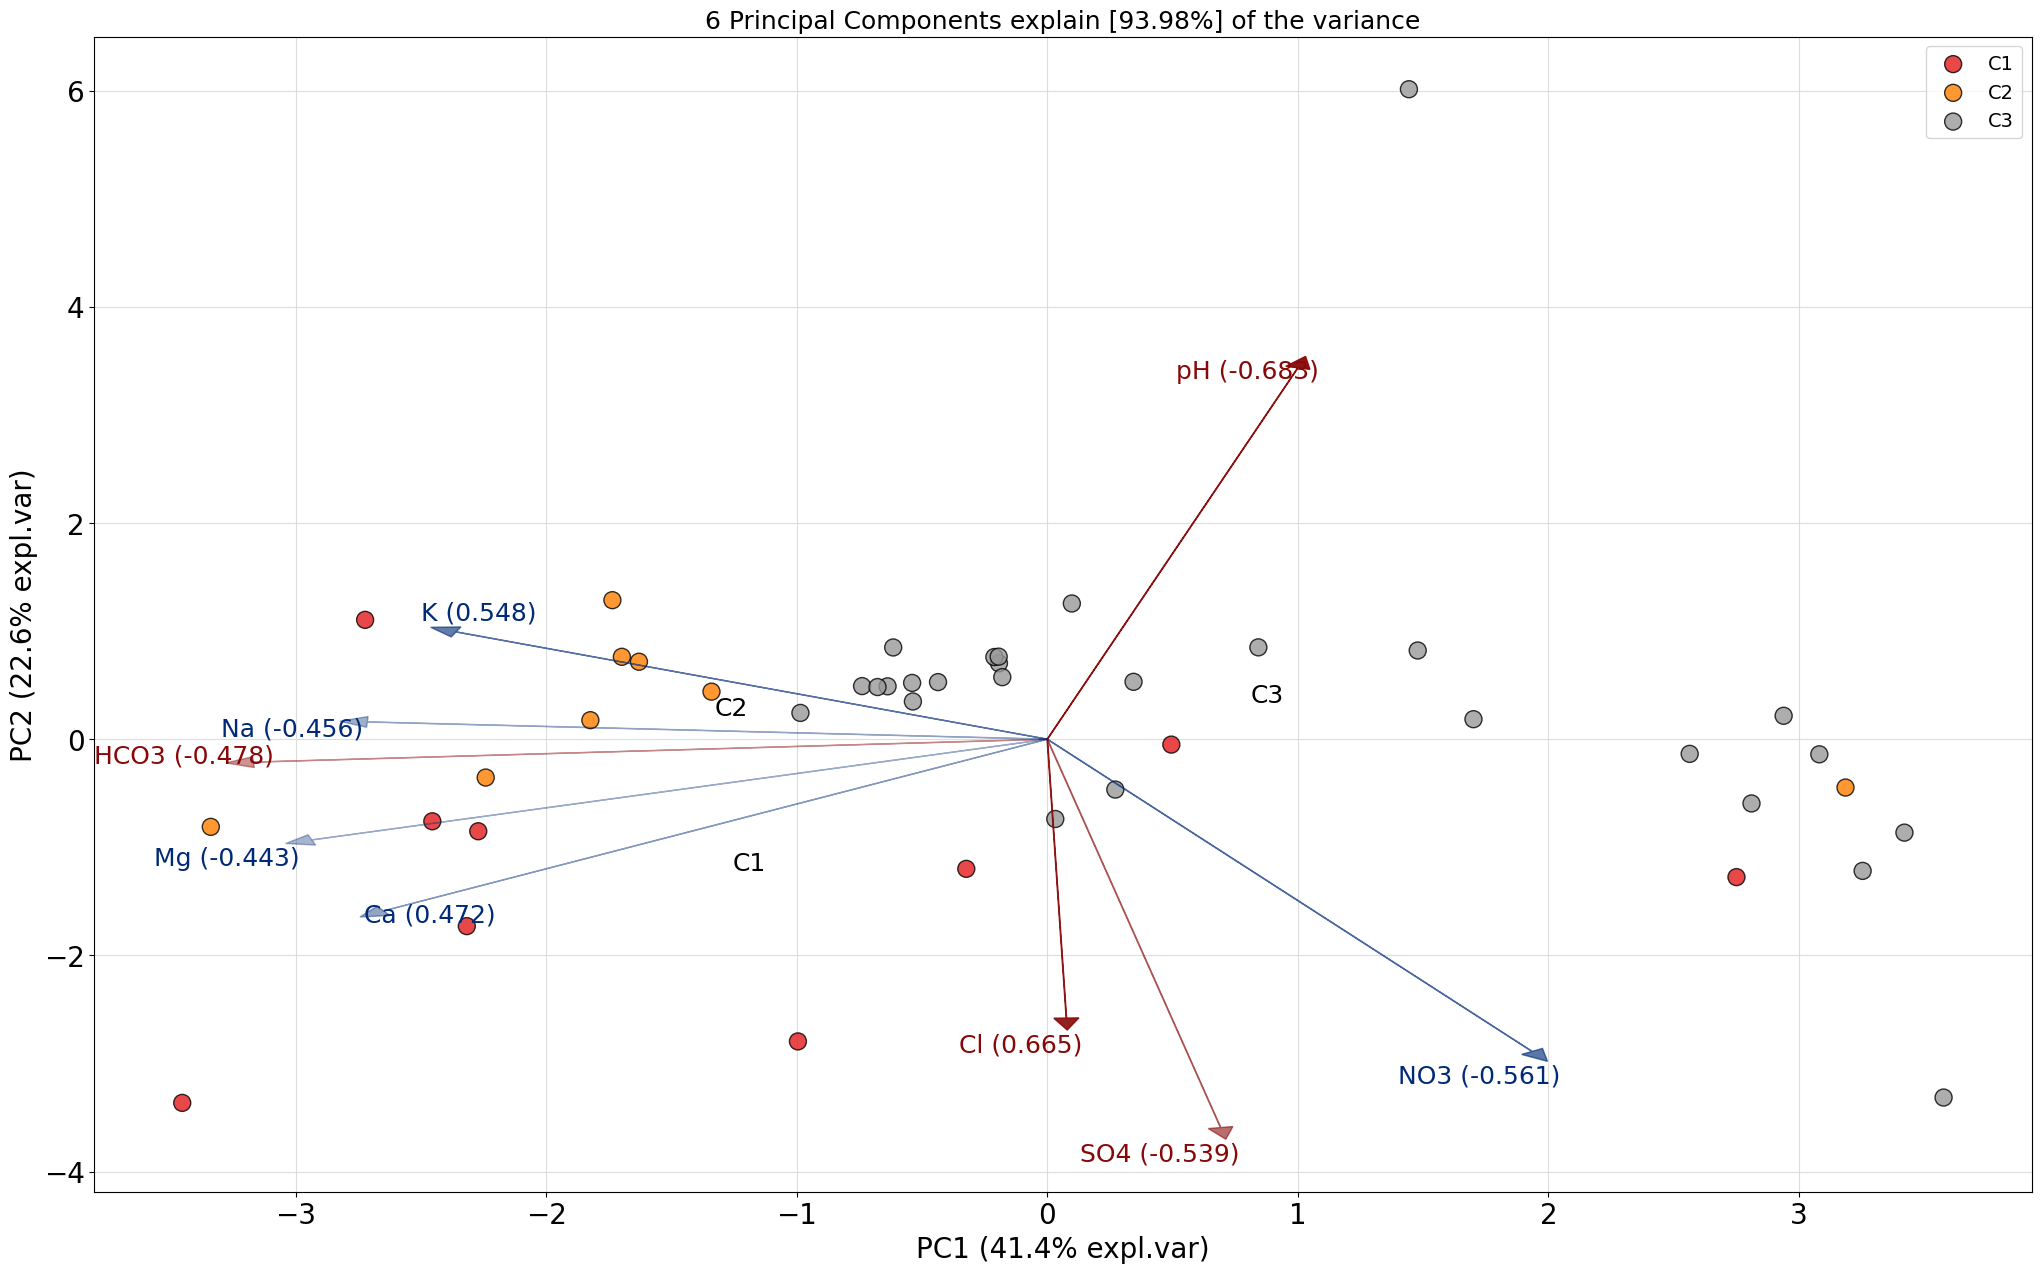

In [19]:
standardisedX['cluster'] = dendrograma['leaves_color_list']
# Set custom classlabels. Coloring is based on the input colormap (cmap).
y= standardisedX['cluster']  #Columna que contiene los clusters
model.biplot(labels=y, cmap='Set1')